## HAR LSTM model

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [3]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [4]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [5]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [6]:
def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [7]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [8]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [9]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [10]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [11]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [12]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [13]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

C:\Users\Shrikant\Anaconda3\envs\tf15\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
C:\Users\Shrikant\Anaconda3\envs\tf15\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [14]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print("timestep of vector dimension is:{}".format(timesteps))
print("input dimension is  :{}".format(input_dim))
print("Numbers of windows with overlapping is:{}".format(len(X_train)))
print("Number of classes is:{}".format(n_classes))

timestep of vector dimension is:128
input dimension is  :9
Numbers of windows with overlapping is:7352
Number of classes is:6


In [15]:
n_classes

6

#### Defining the Architecture of LSTM

In [16]:
# Initializing parameters
epochs = 150
batch_size = 128
n_hidden = 32

In [17]:
# Initiliazing the sequential model
model1 = Sequential()
# Configuring the parameters
model1.add(LSTM(n_hidden,input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model1.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model1.add(Dense(n_classes,activation='sigmoid'))
model1.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Compiling the model
model1.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [19]:
# Training the model
history = model1.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),
                     epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/150
7352/7352 [==============================] - 19s 3ms/step - loss: 1.5712 - acc: 0.3894 - val_loss: 1.4528 - val_acc: 0.4259
Epoch 2/150
7352/7352 [==============================] - 17s 2ms/step - loss: 1.3602 - acc: 0.4429 - val_loss: 1.4376 - val_acc: 0.4296
Epoch 3/150
7352/7352 [==============================] - 18s 2ms/step - loss: 1.2929 - acc: 0.4668 - val_loss: 1.3488 - val_acc: 0.4245
Epoch 4/150
7352/7352 [==============================] - 18s 2ms/step - loss: 1.2183 - acc: 0.4872 - val_loss: 1.2905 - val_acc: 0.3990
Epoch 5/150
7352/7352 [==============================] - 19s 3ms/step - loss: 1.1837 - acc: 0.4852 - val_loss: 1.1706 - val_acc: 0.4659
Epoch 6/150
7352/7352 [==============================] - 18s 2ms/step - loss: 1.0878 - acc: 0.5143 - val_loss: 1.0978 - val_acc: 0.4880
Epoch 7/150
7352/7352 [==============================] - 19s 3ms/step - loss: 1.0113 - acc: 0.5412 - val_loss: 1.0460 - val_acc: 0.5049


Epoch 120/150
7352/7352 [==============================] - 23s 3ms/step - loss: 0.1144 - acc: 0.9574 - val_loss: 0.4432 - val_acc: 0.8928
Epoch 121/150
7352/7352 [==============================] - 27s 4ms/step - loss: 0.1256 - acc: 0.9567 - val_loss: 0.5169 - val_acc: 0.8873
Epoch 122/150
7352/7352 [==============================] - 24s 3ms/step - loss: 0.1488 - acc: 0.9497 - val_loss: 0.5332 - val_acc: 0.8972
Epoch 123/150
7352/7352 [==============================] - 25s 3ms/step - loss: 0.5012 - acc: 0.9115 - val_loss: 0.4888 - val_acc: 0.8904
Epoch 124/150
7352/7352 [==============================] - 23s 3ms/step - loss: 0.1452 - acc: 0.9516 - val_loss: 0.4382 - val_acc: 0.8931
Epoch 125/150
7352/7352 [==============================] - 23s 3ms/step - loss: 0.1407 - acc: 0.9535 - val_loss: 0.3676 - val_acc: 0.9030
Epoch 126/150
7352/7352 [==============================] - 24s 3ms/step - loss: 0.1269 - acc: 0.9547 - val_loss: 0.3894 - val_acc: 0.8992
Epoch 127/150
7352/7352 [=========

In [20]:
# Confusion Matrix
print(confusion_matrix(Y_test, model1.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0         0        0                   0   
SITTING                  2      392        81        0                   1   
STANDING                 0      107       423        2                   0   
WALKING                  0        0         6      459                   5   
WALKING_DOWNSTAIRS       0        0         0        1                 418   
WALKING_UPSTAIRS         0        1         1       10                  17   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            27  
SITTING                           15  
STANDING                           0  
WALKING                           26  
WALKING_DOWNSTAIRS                 1  
WALKING_UPSTAIRS                 442  


In [21]:
score = model1.evaluate(X_test, Y_test)

2947/2947 [==============================] - 9s 3ms/step


In [22]:
score

[0.379760792548977, 0.8971835765184933]

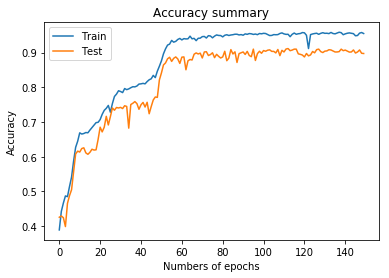

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel("Numbers of epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy summary")
plt.legend(['Train','Test'],loc='upper left')
plt.show()

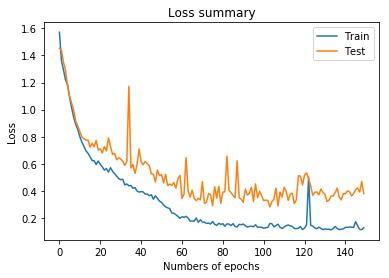

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Numbers of epochs")
plt.ylabel("Loss")
plt.title("Loss summary")
plt.legend(['Train','Test'],loc='best')
plt.show()

### model 2 with single LSTM and 64 LSTM neuron units

In [25]:
# Initiliazing the sequential model
model2 = Sequential()
# Configuring the parameters
model2.add(LSTM(64,input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model2.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model2.add(Dense(n_classes,activation='sigmoid'))
model2.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Compiling the model
model2.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [27]:
# Training the model
history2 = model2.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),
                     epochs=150)

Train on 7352 samples, validate on 2947 samples
Epoch 1/150
7352/7352 [==============================] - 19s 3ms/step - loss: 1.4832 - acc: 0.3648 - val_loss: 1.4112 - val_acc: 0.3682
Epoch 2/150
7352/7352 [==============================] - 20s 3ms/step - loss: 1.2628 - acc: 0.4634 - val_loss: 1.2453 - val_acc: 0.4408
Epoch 3/150
7352/7352 [==============================] - 23s 3ms/step - loss: 1.2136 - acc: 0.4771 - val_loss: 1.2227 - val_acc: 0.5029
Epoch 4/150
7352/7352 [==============================] - 19s 3ms/step - loss: 1.1383 - acc: 0.4924 - val_loss: 1.1433 - val_acc: 0.4869
Epoch 5/150
7352/7352 [==============================] - 18s 2ms/step - loss: 1.1020 - acc: 0.5069 - val_loss: 1.1588 - val_acc: 0.4574
Epoch 6/150
7352/7352 [==============================] - 19s 3ms/step - loss: 1.0799 - acc: 0.5207 - val_loss: 1.0750 - val_acc: 0.5341
Epoch 7/150
7352/7352 [==============================] - 19s 3ms/step - loss: 0.9994 - acc: 0.5653 - val_loss: 0.9610 - val_acc: 0.5965


Epoch 120/150
7352/7352 [==============================] - 23s 3ms/step - loss: 0.0876 - acc: 0.9611 - val_loss: 0.4409 - val_acc: 0.9145
Epoch 121/150
7352/7352 [==============================] - 20s 3ms/step - loss: 0.0880 - acc: 0.9607 - val_loss: 0.5901 - val_acc: 0.9009
Epoch 122/150
7352/7352 [==============================] - 17s 2ms/step - loss: 0.0940 - acc: 0.9616 - val_loss: 0.4040 - val_acc: 0.9006
Epoch 123/150
7352/7352 [==============================] - 17s 2ms/step - loss: 0.0872 - acc: 0.9600 - val_loss: 0.4892 - val_acc: 0.9101
Epoch 124/150
7352/7352 [==============================] - 17s 2ms/step - loss: 0.0841 - acc: 0.9597 - val_loss: 0.7206 - val_acc: 0.8972
Epoch 125/150
7352/7352 [==============================] - 17s 2ms/step - loss: 0.0898 - acc: 0.9596 - val_loss: 0.4337 - val_acc: 0.9101
Epoch 126/150
7352/7352 [==============================] - 18s 2ms/step - loss: 0.0876 - acc: 0.9618 - val_loss: 0.4438 - val_acc: 0.8985
Epoch 127/150
7352/7352 [=========

In [28]:
# Confusion Matrix
print(confusion_matrix(Y_test, model2.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0         0        0                   0   
SITTING                  0      410        80        1                   0   
STANDING                 0      122       410        0                   0   
WALKING                  0        0         0      459                  22   
WALKING_DOWNSTAIRS       0        0         0        1                 417   
WALKING_UPSTAIRS         0        1         0        0                  12   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            27  
SITTING                            0  
STANDING                           0  
WALKING                           15  
WALKING_DOWNSTAIRS                 2  
WALKING_UPSTAIRS                 458  


In [29]:
score = model2.evaluate(X_test, Y_test)

2947/2947 [==============================] - 9s 3ms/step


In [30]:
score

[0.5977042395600973, 0.9039701391245334]

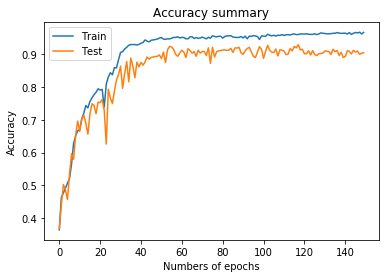

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.xlabel("Numbers of epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy summary")
plt.legend(['Train','Test'],loc='best')
plt.show()

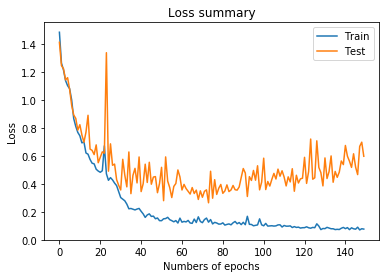

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.xlabel("Numbers of epochs")
plt.ylabel("Loss")
plt.title("Loss summary")
plt.legend(['Train','Test'],loc='best')
plt.show()

## Model 3 with 2 LSTM layers and 32 LSTM neurons units

In [33]:
# Initiliazing the sequential model
model3 = Sequential()
# Configuring the parameters
model3.add(LSTM(32,input_shape=(timesteps, input_dim),return_sequences=True))
# Adding a dropout layer
model3.add(Dropout(0.5))
model3.add(LSTM(32))
model3.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model3.add(Dense(n_classes,activation='sigmoid'))
model3.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 198       
Total params: 13,894
Trainable params: 13,894
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Compiling the model
model3.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [35]:
# Training the model
history3 = model3.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),
                     epochs=100)

Train on 7352 samples, validate on 2947 samples
Epoch 1/100
7352/7352 [==============================] - 50s 7ms/step - loss: 1.5089 - acc: 0.4200 - val_loss: 1.3547 - val_acc: 0.4208
Epoch 2/100
7352/7352 [==============================] - 35s 5ms/step - loss: 1.2725 - acc: 0.4882 - val_loss: 1.2151 - val_acc: 0.5110
Epoch 3/100
7352/7352 [==============================] - 34s 5ms/step - loss: 1.1583 - acc: 0.5243 - val_loss: 1.1136 - val_acc: 0.5219
Epoch 4/100
7352/7352 [==============================] - 35s 5ms/step - loss: 1.0467 - acc: 0.5827 - val_loss: 1.0232 - val_acc: 0.5619
Epoch 5/100
7352/7352 [==============================] - 36s 5ms/step - loss: 0.9231 - acc: 0.6175 - val_loss: 0.9304 - val_acc: 0.6291
Epoch 6/100
7352/7352 [==============================] - 36s 5ms/step - loss: 0.8508 - acc: 0.6378 - val_loss: 0.8052 - val_acc: 0.6783
Epoch 7/100
7352/7352 [==============================] - 35s 5ms/step - loss: 0.8010 - acc: 0.6453 - val_loss: 0.7770 - val_acc: 0.6634


In [36]:
# Confusion Matrix
print(confusion_matrix(Y_test, model3.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 537        0         0        0                   0   
SITTING                  2      362       116        1                   1   
STANDING                 0       45       486        1                   0   
WALKING                  0        0         0      473                   1   
WALKING_DOWNSTAIRS       0        0         0        3                 401   
WALKING_UPSTAIRS         0        0         0       23                   1   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            9  
STANDING                           0  
WALKING                           22  
WALKING_DOWNSTAIRS                16  
WALKING_UPSTAIRS                 447  


In [37]:
scores = model3.evaluate(X_test, Y_test)

2947/2947 [==============================] - 17s 6ms/step


In [38]:
scores

[0.4626269695854334, 0.9182219205972175]

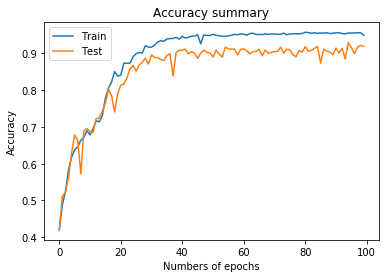

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history3.history['acc'])
plt.plot(history3.history['val_acc'])
plt.xlabel("Numbers of epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy summary")
plt.legend(['Train','Test'],loc='best')
plt.show()

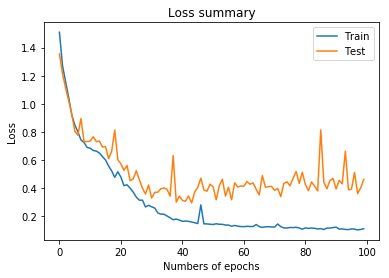

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.xlabel("Numbers of epochs")
plt.ylabel("Loss")
plt.title("Loss summary")
plt.legend(['Train','Test'],loc='best')
plt.show()

## Model 4 with 2 LSTM layers and 64 LSTM neurons units

In [44]:
# Initiliazing the sequential model
model4 = Sequential()
# Configuring the parameters
model4.add(LSTM(64,input_shape=(timesteps, input_dim),return_sequences=True))
# Adding a dropout layer
model4.add(Dropout(0.5))
model4.add(LSTM(64))
model4.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model4.add(Dense(n_classes,activation='sigmoid'))
model4.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 128, 64)           18944     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128, 64)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 390       
Total params: 52,358
Trainable params: 52,358
Non-trainable params: 0
_________________________________________________________________


In [45]:
# Compiling the model
model4.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [46]:
# Training the model
history4 = model4.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),
                     epochs=100)

Train on 7352 samples, validate on 2947 samples
Epoch 1/100
7352/7352 [==============================] - 35s 5ms/step - loss: 1.3523 - acc: 0.4470 - val_loss: 1.5567 - val_acc: 0.3125
Epoch 2/100
7352/7352 [==============================] - 36s 5ms/step - loss: 1.1117 - acc: 0.5214 - val_loss: 1.0850 - val_acc: 0.5545
Epoch 3/100
7352/7352 [==============================] - 34s 5ms/step - loss: 0.9476 - acc: 0.5887 - val_loss: 0.9974 - val_acc: 0.5948
Epoch 4/100
7352/7352 [==============================] - 33s 4ms/step - loss: 0.8514 - acc: 0.6049 - val_loss: 0.8233 - val_acc: 0.6396
Epoch 5/100
7352/7352 [==============================] - 33s 4ms/step - loss: 0.7628 - acc: 0.6511 - val_loss: 0.9773 - val_acc: 0.5979
Epoch 6/100
7352/7352 [==============================] - 33s 4ms/step - loss: 0.7403 - acc: 0.6479 - val_loss: 0.7885 - val_acc: 0.6393
Epoch 7/100
7352/7352 [==============================] - 33s 5ms/step - loss: 0.7244 - acc: 0.6642 - val_loss: 0.7917 - val_acc: 0.6580


In [47]:
# Confusion Matrix
print(confusion_matrix(Y_test, model4.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0        25        0                   0   
SITTING                  3      436        51        0                   1   
STANDING                 0      112       417        2                   0   
WALKING                  0        2         1      466                   0   
WALKING_DOWNSTAIRS       0        0         0        0                 415   
WALKING_UPSTAIRS         0        0         0        2                   5   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             2  
SITTING                            0  
STANDING                           1  
WALKING                           27  
WALKING_DOWNSTAIRS                 5  
WALKING_UPSTAIRS                 464  


In [48]:
score4 = model4.evaluate(X_test, Y_test)

2947/2947 [==============================] - 17s 6ms/step


In [50]:
score4

[0.4141320268444936, 0.9189005768578216]

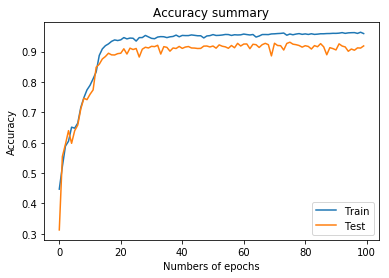

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history4.history['acc'])
plt.plot(history4.history['val_acc'])
plt.xlabel("Numbers of epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy summary")
plt.legend(['Train','Test'],loc='best')
plt.show()

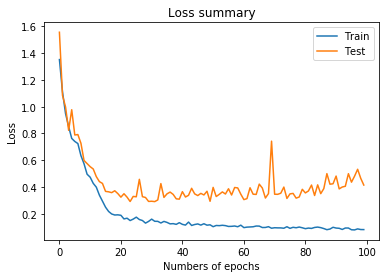

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.xlabel("Numbers of epochs")
plt.ylabel("Loss")
plt.title("Loss summary")
plt.legend(['Train','Test'],loc='best')
plt.show()

In [59]:
# Initiliazing the sequential model
model5 = Sequential()
# Configuring the parameters
model5.add(LSTM(128,input_shape=(timesteps, input_dim),return_sequences=True))
# Adding a dropout layer
model5.add(Dropout(0.5))

model5.add(LSTM(64,return_sequences=True))
model5.add(Dropout(0.5))

model5.add(LSTM(32))
model5.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model5.add(Dense(n_classes,activation='sigmoid'))
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 128, 128)          70656     
_________________________________________________________________
dropout_18 (Dropout)         (None, 128, 128)          0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 128, 64)           49408     
_________________________________________________________________
dropout_19 (Dropout)         (None, 128, 64)           0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_20 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 198       
Total para

In [60]:
# Compiling the model
model5.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [61]:
# Training the model
history5 = model5.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),
                     epochs=100)

Train on 7352 samples, validate on 2947 samples
Epoch 1/100
7352/7352 [==============================] - 53s 7ms/step - loss: 1.5547 - acc: 0.3655 - val_loss: 1.7976 - val_acc: 0.2827
Epoch 2/100
7352/7352 [==============================] - 55s 8ms/step - loss: 1.4058 - acc: 0.3942 - val_loss: 1.3183 - val_acc: 0.5165
Epoch 3/100
7352/7352 [==============================] - 67s 9ms/step - loss: 1.2437 - acc: 0.4761 - val_loss: 1.2336 - val_acc: 0.4425
Epoch 4/100
7352/7352 [==============================] - 80s 11ms/step - loss: 1.2448 - acc: 0.4359 - val_loss: 1.1914 - val_acc: 0.4941
Epoch 5/100
7352/7352 [==============================] - 84s 11ms/step - loss: 1.0748 - acc: 0.5467 - val_loss: 0.9838 - val_acc: 0.6094
Epoch 6/100
7352/7352 [==============================] - 86s 12ms/step - loss: 1.0465 - acc: 0.5505 - val_loss: 1.0104 - val_acc: 0.5684
Epoch 7/100
7352/7352 [==============================] - 74s 10ms/step - loss: 0.9293 - acc: 0.6041 - val_loss: 0.8930 - val_acc: 0.5

In [62]:
# Confusion Matrix
print(confusion_matrix(Y_test, model5.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 537        0         0        0                   0   
SITTING                 22      414        54        0                   1   
STANDING                 0      107       424        1                   0   
WALKING                  0        0         0      432                   7   
WALKING_DOWNSTAIRS       0        0         0        0                 412   
WALKING_UPSTAIRS         0        0         1        0                  22   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            0  
STANDING                           0  
WALKING                           57  
WALKING_DOWNSTAIRS                 8  
WALKING_UPSTAIRS                 448  


In [63]:
score5 = model5.evaluate(X_test, Y_test)

2947/2947 [==============================] - 27s 9ms/step


In [64]:
score5

[0.3722532238988386, 0.9049881235154394]

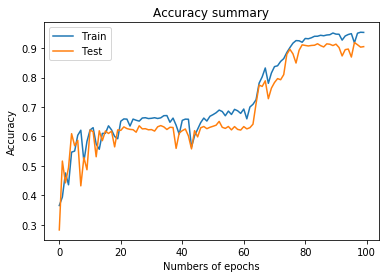

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history5.history['acc'])
plt.plot(history5.history['val_acc'])
plt.xlabel("Numbers of epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy summary")
plt.legend(['Train','Test'],loc='best')
plt.show()

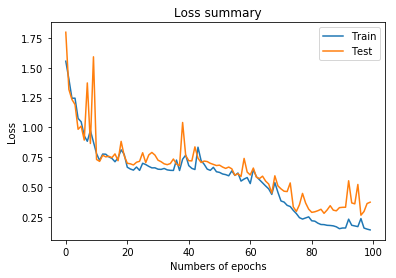

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.xlabel("Numbers of epochs")
plt.ylabel("Loss")
plt.title("Loss summary")
plt.legend(['Train','Test'],loc='best')
plt.show()

### Analysis of Human Activity Recoginition using deep learning models

In [70]:
df = pd.DataFrame(columns=['Model Nos','LSTM Layres','LSTM Cells','Epochs','Accuracy %','Loss %'])
df = df.append(pd.DataFrame([['model 1','1 layers','32','150',0.8971*100,0.3797*100]],
                            columns=['Model Nos','LSTM Layres','LSTM Cells','Epochs','Accuracy %','Loss %']))
df = df.append(pd.DataFrame([['model 2','1 layers','64','150',0.9039*100,0.5977*100]],
                            columns=['Model Nos','LSTM Layres','LSTM Cells','Epochs','Accuracy %','Loss %']))
df = df.append(pd.DataFrame([['model 3','2 layers','32','100',0.9182*100,0.4626*100]],
                            columns=['Model Nos','LSTM Layres','LSTM Cells','Epochs','Accuracy %','Loss %']))

df = df.append(pd.DataFrame([['model 4','2 layers','64','100',0.9189*100,0.4141*100]],
                            columns=['Model Nos','LSTM Layres','LSTM Cells','Epochs','Accuracy %','Loss %']))

df = df.append(pd.DataFrame([['model 5','3 layers','128','100',0.9049*100,0.3722*100]],
                            columns=['Model Nos','LSTM Layres','LSTM Cells','Epochs','Accuracy %','Loss %']))


df.reset_index(drop=True,inplace=True)

In [71]:
df

,Model Nos,LSTM Layres,LSTM Cells,Epochs,Accuracy %,Loss %
0,model 1,1 layers,32,150,89.71,37.97
1,model 2,1 layers,64,150,90.39,59.77
2,model 3,2 layers,32,100,91.82,46.26
3,model 4,2 layers,64,100,91.89,41.41
4,model 5,3 layers,128,100,90.49,37.22


### Conclusion 

- We did Exploratory data analysis on HAR dataset.
- We applied the classical machine learning algorithm such as Logistic Regression,Liner SVC,SVM with kernels,Decision Tree,Gradient Boosting Decision Tree,Random Forest.
- We tuned the hyperparametrs to find out best hyperparametres for each ML algorithms using GridSearchCV.
- Plotted the confusion matrix.
- Applied the deep learning model such as **LSTM**(Long Short Term Memory).
- Applied **LSTM** with differents numbers of layers and nuerons to find out the best accuracy for this case study.
- Classical ML algorithm give the higher accuracy(Best accuracy is :**96.81%** for **Liner SVC**) compare to deep learning model **LSTM**( Best accuracy is **91.89%**).
- plotted train and validation error for LSTM.
- Here we are getting low accuracy for deep learning models **LSTM** than classical ML algorithms because deep learning model is applied where there is large numbers of data points.
